In [1]:
import pandas as pd
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from matplotlib.colors import ListedColormap
from nilearn import datasets, plotting, image
import matplotlib.cm as cm
import matplotlib

In [2]:
# Load the Excel file
excel_path = '/Users/rachelmorse/Documents/2023:2024/CR & BM Project/Task invariant network/Shirer atlas.xlsx'
df = pd.read_excel(excel_path)

# Filter rows where ROI_network is 'AS'
sn = df[df['ROI_network'] == 'AS']

# Extract the corresponding volume indices
sn_volumes = sn['ROI'].tolist()

# Repeat for the other networks
dmn = df[df['ROI_network'].str.contains('dDMN|vDMN')]
dmn_volumes = dmn['ROI'].tolist()

ecn = df[df['ROI_network'].str.contains('RECN|LECN')]
ecn_volumes = ecn['ROI'].tolist()

In [3]:
# Load the Shirer atlas NIFTI file
atlas_path = '/Users/rachelmorse/Documents/2023:2024/CR & BM Project/Task invariant network/subrois_shirer2012_mod_4d.nii.gz' 
atlas_img = nib.load(atlas_path)

Text(0.5, 0.98, 'Anterior Salience Network')

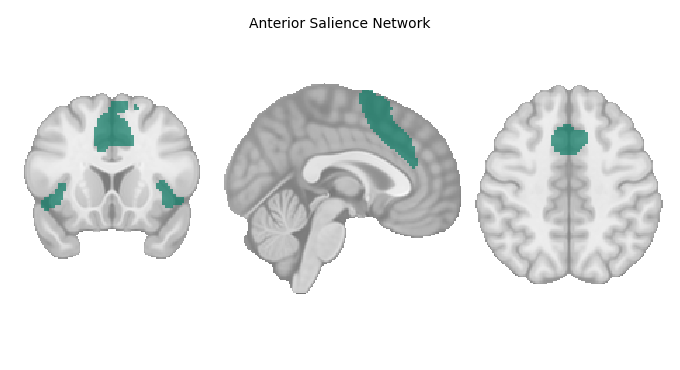

In [23]:
# Make a mask of the Anterior Salience Network

# Stack all AN ROIs into one 4D image
sn_data = atlas_img.get_fdata()[..., sn_volumes]

# Sum the AN ROIs to create a 3D mask
sn_mask_data = np.sum(sn_data, axis=-1)
sn_mask_data = (sn_mask_data > 0).astype(np.float32) 

sn_mask_img = nib.Nifti1Image(sn_mask_data, affine=atlas_img.affine)

std_brain = datasets.load_mni152_template()
# Resample to match std_brain
sn_mask_img = image.resample_to_img(sn_mask_img, std_brain, interpolation='nearest')

# Plot Salience Network
custom_cmap = ListedColormap(['#0D7C66'])

plotting.plot_roi(sn_mask_img, 
                  bg_img=std_brain, 
                  display_mode='ortho',
                  cmap=custom_cmap, 
                  black_bg=False, 
                  draw_cross=False,                   
                  annotate=False  # Add to remove coordinate labels
                  )

# Show the plots
plt.suptitle('Anterior Salience Network', color='black', backgroundcolor='white', size=10)

Text(0.5, 0.98, 'Default Mode Network')

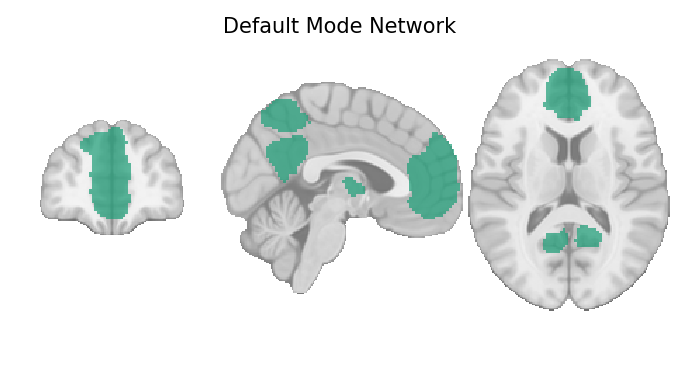

In [5]:
# Make a mask of the Default Mode Network

# Stack all DMN ROIs into one 4D image
dmn_data = atlas_img.get_fdata()[..., dmn_volumes]

# Sum the DMN ROIs to create a 3D mask
dmn_mask_data = np.sum(dmn_data, axis=-1)
dmn_mask_data = (dmn_mask_data > 0).astype(np.float32) 

dmn_mask_img = nib.Nifti1Image(dmn_mask_data, affine=atlas_img.affine)

# Resample to match std_brain
dmn_mask_img = image.resample_to_img(dmn_mask_img, std_brain, interpolation='nearest')

# Plot the mask image on top of a standard brain image
plotting.plot_roi(dmn_mask_img, 
                  bg_img=std_brain,
                  display_mode='ortho',
                  cmap='Dark2', 
                  black_bg=False, 
                  draw_cross=False,
                  annotate=False  # Add to remove coordinate labels
                  )

# Show the plots
plt.suptitle('Default Mode Network', color='black', backgroundcolor='white', size=15)

Text(0.5, 0.98, 'Executive Control Network')

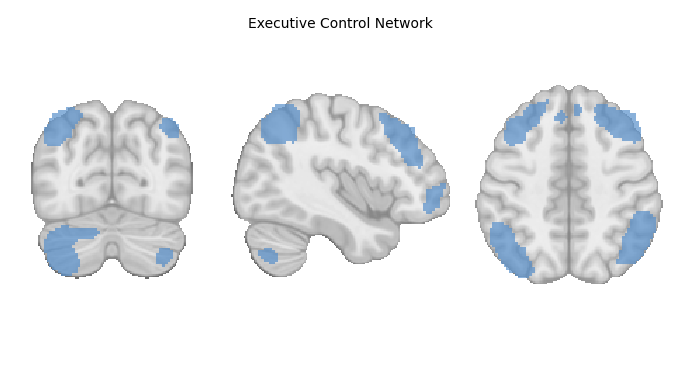

In [12]:
# Make a mask of the Executive Control Network

# Stack all DMN ROIs into one 4D image
ecn_data = atlas_img.get_fdata()[..., ecn_volumes]

# Sum the DMN ROIs to create a 3D mask
ecn_mask_data = np.sum(ecn_data, axis=-1)
ecn_mask_data = (ecn_mask_data > 0).astype(np.float32) 

ecn_mask_img = nib.Nifti1Image(ecn_mask_data, affine=atlas_img.affine)

# Resample to match std_brain
ecn_mask_img = image.resample_to_img(ecn_mask_img, std_brain, interpolation='nearest')

custom_cmap = ListedColormap(['#578FCA'])

# Plot Salience Network
plotting.plot_roi(ecn_mask_img, 
                  bg_img=std_brain, 
                  black_bg=False, 
                  cmap=custom_cmap, 
                  display_mode='ortho',
                  draw_cross=False,
                #   display_mode="z", # Remove these comments to focus on one view of the ECN
                  cut_coords=[42, -73, 46],
                  annotate=False  # Add to remove coordinate labels
                  )
                  
# Show the plots
plt.suptitle('Executive Control Network', color='black', backgroundcolor='white', size=10)

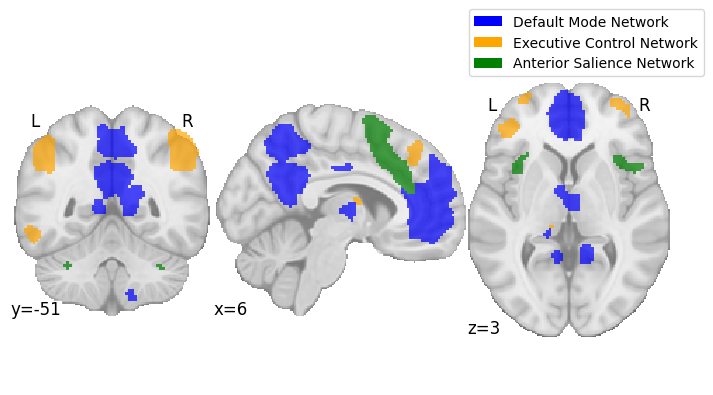

In [7]:
# Assign distinct labels to each network
dmn_mask_data = (dmn_mask_data > 0).astype(np.int32) * 1  # Label as 1
ecn_mask_data = (ecn_mask_data > 0).astype(np.int32) * 2  # Label as 2
sn_mask_data = (sn_mask_data > 0).astype(np.int32) * 3    # Label as 3

# Combine the labeled data
combined_data = dmn_mask_data + ecn_mask_data + sn_mask_data
combined_mask_data = combined_data.astype(np.float32)

# When the masks overlap (eg a ROI is in two networks), label as highest value
combined_mask_data = np.maximum.reduce([dmn_mask_data, ecn_mask_data, sn_mask_data])

combined_mask_img = nib.Nifti1Image(combined_mask_data, affine=atlas_img.affine)

custom_cmap = ListedColormap(['blue', 'orange', 'green'])

# Resample combined_mask_img to match std_brain
resampled_img = image.resample_to_img(combined_mask_img, std_brain, interpolation='nearest')

# Plot the resampled image
plot = plotting.plot_roi(
       resampled_img,
       display_mode='ortho',
       cmap=custom_cmap,
       bg_img=std_brain,
       black_bg=False,
       draw_cross=False,
       cut_coords=(6, -51, 3)
)

# Create a legend manually
legend_elements = [
    Patch(facecolor='blue', label='Default Mode Network'),
    Patch(facecolor='orange', label='Executive Control Network'),
    Patch(facecolor='green', label='Anterior Salience Network')
]

# Add the legend outside the plot
plt.legend(handles=legend_elements, loc='lower right', bbox_to_anchor=(1.2, 1))

plotting.show()

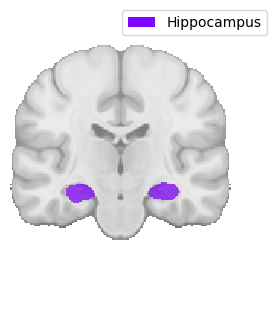

In [11]:
# Make a plot of the hippocampus structure

# Fetch the Harvard-Oxford subcortical atlas
atlas = datasets.fetch_atlas_harvard_oxford('sub-maxprob-thr25-1mm')

# Load the atlas and the labels
atlas_img = atlas.maps
atlas_data = atlas_img.get_fdata()
atlas_labels = atlas.labels

# Find the indices for the left and right hippocampus
hippocampus_indices = [i for i, label in enumerate(atlas_labels) if 'Hippocampus' in label]

# Create a mask for the hippocampus
hippocampus_mask_data = np.isin(atlas_data, hippocampus_indices).astype(float)
hippocampus_mask = nib.Nifti1Image(hippocampus_mask_data, affine=atlas_img.affine)

# Use a colormap and get the specific color used in the plot
cmap = matplotlib.colormaps['rainbow']
hippocampus_color = cmap(1)  

# Plot the hippocampus in MNI space
plot = plotting.plot_roi(
    hippocampus_mask,
    display_mode='y',
    cut_coords=[-20],
    bg_img=std_brain,
    black_bg=False,
    cmap='rainbow',
    annotate=False  # Add to remove coordinate labels
)

# Create a legend manually with a matching color
legend_elements = [
    Patch(facecolor=hippocampus_color, label='Hippocampus')
]

# Add the legend outside the plot
plt.legend(handles=legend_elements, loc='lower right', bbox_to_anchor=(1.2, 1))

plotting.show()